In [20]:

import pandas as pd
from azureml.core import Workspace, Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import joblib

In [2]:

# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '1187e426-ca2b-4583-ac13-689c46b37588'
resource_group = 'ml'
workspace_name = 'new_mlmodel'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='sale')
#dataset.download(target_path='.', overwrite=False)


In [3]:
pip install Prophet


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
from prophet import Prophet



/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [5]:
import pandas as pd

# Download the dataset locally
file_paths = dataset.download(target_path='.', overwrite=True)

# file_paths is a list of downloaded files
print("Files downloaded:", file_paths)

# Assuming it's a CSV file
df = pd.read_csv(file_paths[0])

print(df.head())


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/mlflow/__init__.py:41: UserWarning: Versions of mlflow (3.1.1) and mlflow-skinny (2.22.1) are different. This may lead to unexpected behavior. Please install the same version of both packages.
  mlflow.mismatch._check_version_mismatch()


{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
Files downloaded: ['/mnt/batch/tasks/shared/LS_root/mounts/clusters/mlmodel/code/Users/admin/Book1.csv']
  INVHED_TXNDATE  orders        sale
0      9/30/2024    1901  4553163.04
1      10/1/2024    1842  4286333.28
2      10/2/2024    1822  4318159.78
3      10/3/2024    1793  4083143.92
4      10/4/2024    1910  4217155.17


In [6]:
df.columns 

Index(['INVHED_TXNDATE', 'orders', 'sale'], dtype='object')

In [7]:
import pandas as pd

# Ensure date column is in datetime format
df['INVHED_TXNDATE'] = pd.to_datetime(df['INVHED_TXNDATE'])

# Prepare for Prophet
df_prophet = df.rename(columns={
    'INVHED_TXNDATE': 'ds',
    'sale': 'y'
})[['ds', 'y']]


In [8]:
# Use last 30 days (or adjust) as test set
train = df_prophet.iloc[:-30]
test = df_prophet.iloc[-30:]


In [9]:
model = Prophet(
    seasonality_mode='additive',   # can change to 'multiplicative'
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(train)

11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
# 4. Forecast on test period
# ---------------------------
future = model.make_future_dataframe(periods=30, freq='D')
forecast = model.predict(future)

# Extract only the test period predictions
forecast_test = forecast.set_index('ds').loc[test['ds']]


In [11]:
# 5. Evaluation
# ---------------------------
y_true = test['y'].values
y_pred = forecast_test['yhat'].values


In [12]:
# 6. Fine-tuning example
# ---------------------------
# You can adjust seasonality or add holidays/regressors
# Example: enable daily seasonality, change growth type
model_tuned = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    growth='linear'
)

model_tuned.fit(train)
future_tuned = model_tuned.make_future_dataframe(periods=30, freq='D')
forecast_tuned = model_tuned.predict(future_tuned)


11:10:47 - cmdstanpy - INFO - Chain [1] start processing
11:10:47 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 373537.46
RMSE: 518760.04


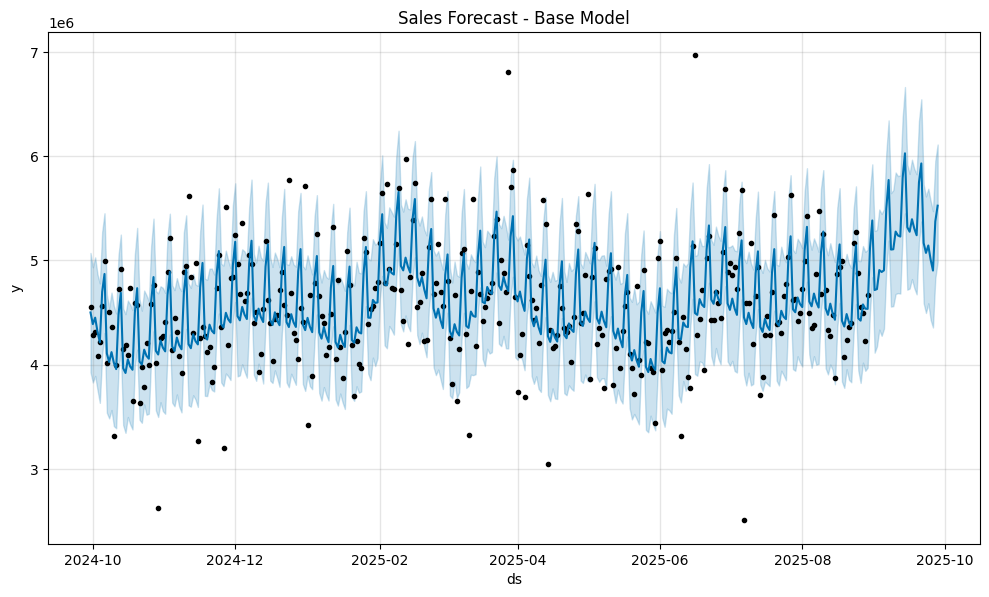

In [14]:
# 7. Plot results
# ---------------------------
# Plot overall forecast
fig1 = model.plot(forecast)
plt.title("Sales Forecast - Base Model")
plt.show()

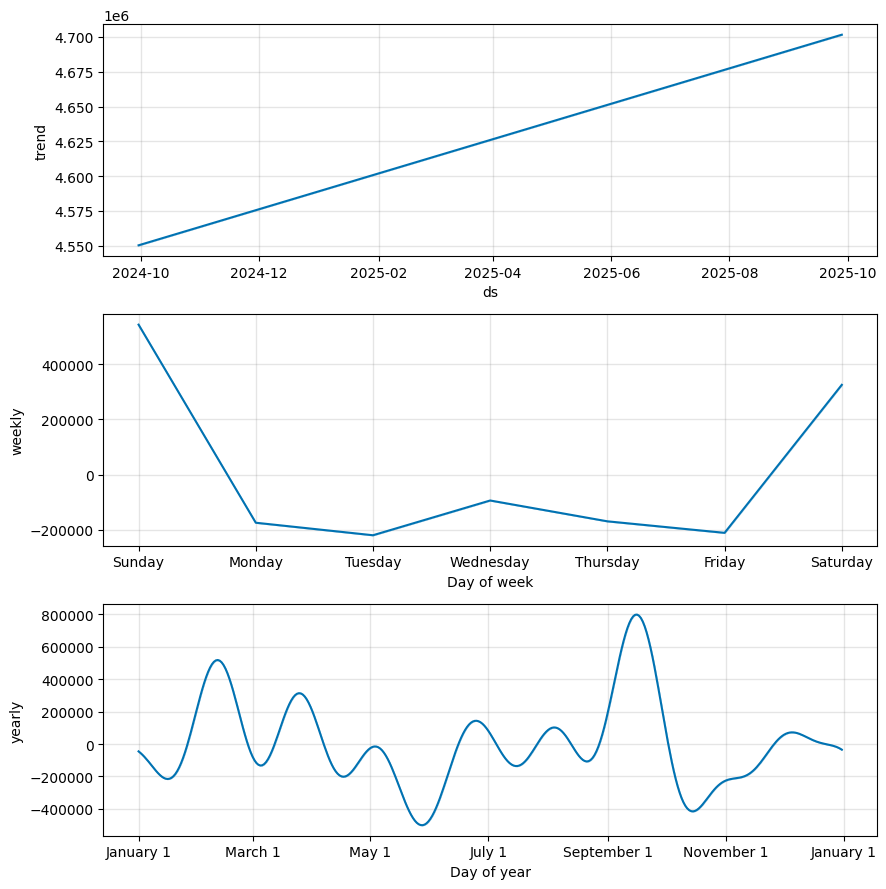

In [15]:
# Plot forecast components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()


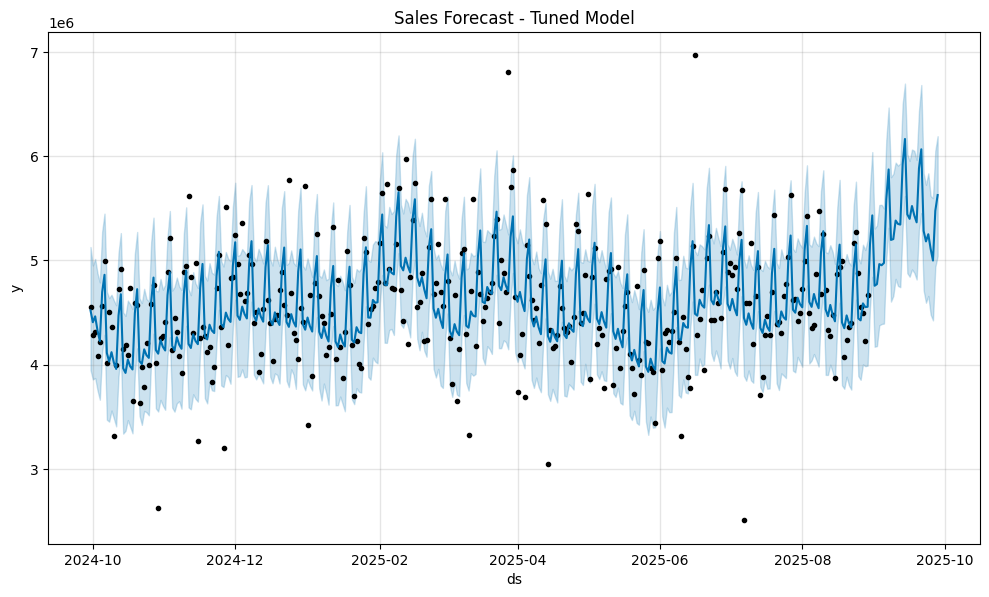

In [16]:
# Compare tuned model
fig3 = model_tuned.plot(forecast_tuned)
plt.title("Sales Forecast - Tuned Model")
plt.show()

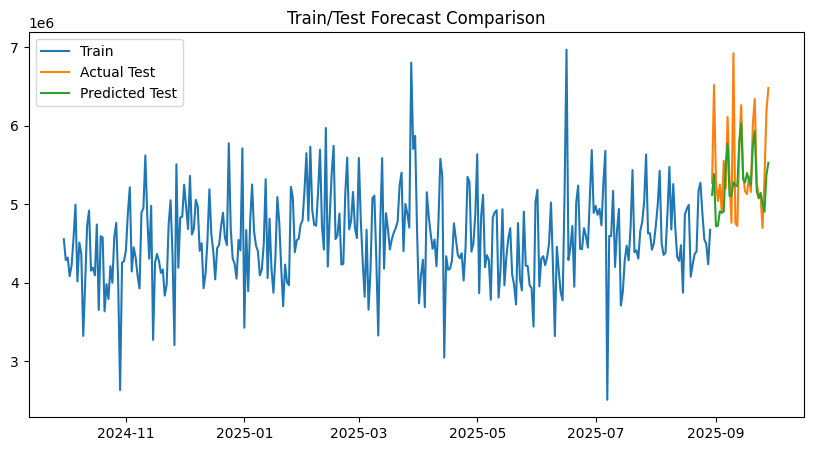

In [17]:
# 8. Compare actual vs predicted (test period)
# ---------------------------
plt.figure(figsize=(10,5))
plt.plot(train['ds'], train['y'], label="Train")
plt.plot(test['ds'], test['y'], label="Actual Test")
plt.plot(test['ds'], forecast_test['yhat'], label="Predicted Test")
plt.legend()
plt.title("Train/Test Forecast Comparison")
plt.show()

11:12:22 - cmdstanpy - INFO - Chain [1] start processing
11:12:22 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
444 2025-12-18  5.255635e+06  4.697765e+06  5.854890e+06
445 2025-12-19  5.234165e+06  4.664674e+06  5.838956e+06
446 2025-12-20  5.841355e+06  5.249992e+06  6.387269e+06
447 2025-12-21  6.140360e+06  5.570454e+06  6.709197e+06
448 2025-12-22  5.287342e+06  4.710480e+06  5.857358e+06
449 2025-12-23  5.206362e+06  4.642074e+06  5.836297e+06
450 2025-12-24  5.385416e+06  4.815435e+06  5.909318e+06
451 2025-12-25  5.242200e+06  4.686634e+06  5.805911e+06
452 2025-12-26  5.215477e+06  4.603729e+06  5.819472e+06
453 2025-12-27  5.818094e+06  5.219843e+06  6.378602e+06


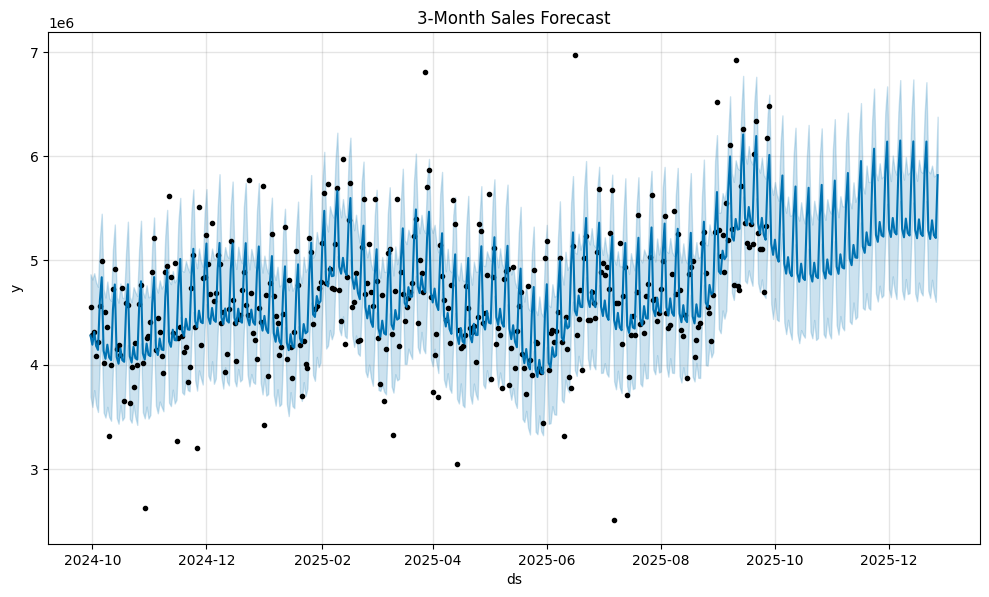

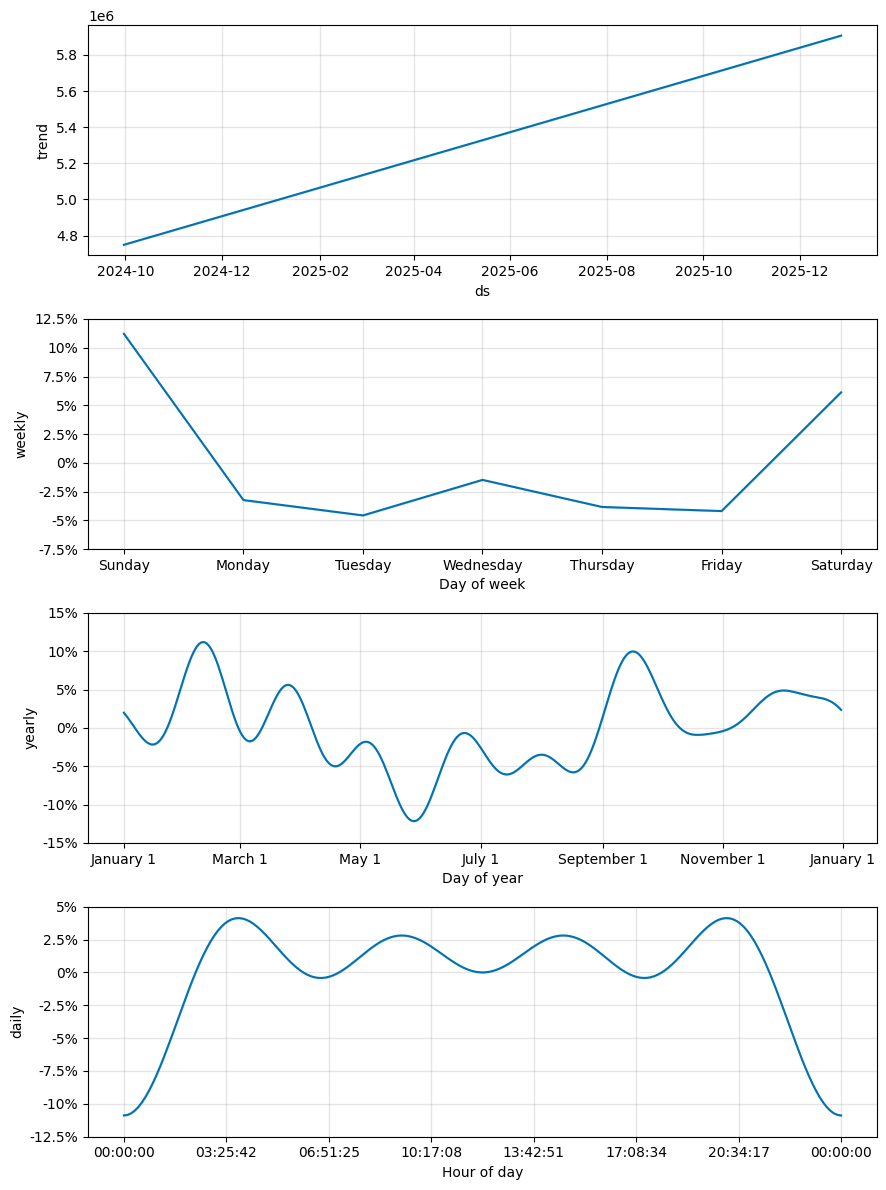

In [18]:
# 1. Retrain the model on ALL data (train + test)
final_model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)
final_model.fit(df_prophet)  # use full dataset now

# 2. Forecast 90 days ahead
future_3m = final_model.make_future_dataframe(periods=90, freq='D')
forecast_3m = final_model.predict(future_3m)

# 3. Show last 10 predictions
print(forecast_3m[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10))

# 4. Plot the 3-month forecast
fig = final_model.plot(forecast_3m)
plt.title("3-Month Sales Forecast")
plt.show()

# 5. Plot forecast components (trend, weekly, yearly patterns)
fig2 = final_model.plot_components(forecast_3m)
plt.show()


In [21]:
joblib.dump(model, "sales_forecast_model.pkl")
print("✅ Model saved as sales_forecast_model.pkl")

✅ Model saved as sales_forecast_model.pkl
